In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import GroupKFold, StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, confusion_matrix, roc_curve, precision_recall_curve, auc, f1_score, cohen_kappa_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.feature_selection import RFE, SelectFromModel, RFECV
from sklearn.tree import DecisionTreeClassifier


from IPython import display
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import cm

from pylab import rcParams

import os
import re
import time
import warnings
warnings.filterwarnings('ignore')

seed = 9001
np.random.seed(seed)

c:\users\antra\appdata\local\programs\python\python36\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
c:\users\antra\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Read in processed extracted 6 hour window data training and test set

In [5]:
# training set
X_all = pd.read_csv('6hour_Xtrain.csv')
y_all = pd.read_csv('6hour_ytrain.csv')

# test set
X_test = pd.read_csv('6hour_Xtest.csv')
y_test = pd.read_csv('6hour_ytest.csv')

/content/drive/My Drive/sepsis


In [6]:
print(X_all.shape)
print(X_test.shape)

(1080424, 64)
(270106, 64)


### Define threshold that gives best F1-score

In [0]:
def performance2(y, y_pred, print_ = 1, *args):   
    """ Calculate performance measures for a given ground truth classification y and predicted 
    probabilities y_pred. If *args is provided a pre-defined threshold is used to calculate the performance.
    If not, the threshold giving the best mean sensitivity and specificity is selected. The AUC is calculated
    for a range of thresholds using the metrics package from sklearn. """

    # xx and yy values for ROC curve
    fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
    # area under the ROC curve
    AUC = auc(fpr, tpr)

    # xx and yy values for AUPR
    precision, recall, thresholds = precision_recall_curve(y, y_pred, pos_label=1)
    # convert to f1-score
    fscore = (2*precision*recall) / (precision+recall)
    fscore[np.isnan(fscore)] = 0

    # if a threshold is specified, use it
    if args:
        threshold = args[0]
    else:
    # if a threshold is not specified, we will choose the threshold that gives the best f1-score
        ix = np.argmax(fscore)
        threshold = thresholds[ix]        
        
    # transform the predicted probability into a binary classification
    y_pred[y_pred >= threshold] = 1
    y_pred[y_pred < threshold] = 0
    
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        
    # basic accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # for auc
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    
    # for f1-score
    precision1 = tp/(tp+fp)
    recall1 = sensitivity # detection rate
    
    # for false alarm rate
    fpr2 = fp/(fp+tn) # distinguish with false positive rate from calculating AUC
    fnr = fn/(fn+tp)
    
    # f1-score
    f1 = max(fscore)

    # kappa score
    kappa = cohen_kappa_score(y, y_pred)

    
    # print the performance and plot the ROC curve    
    if print_ == 1:
        print('Threshold: ' + str(round(threshold, 2)))
        print('TP: ' + str(tp))
        print('TN: ' + str(tn))
        print('FP: ' + str(fp))
        print('FN: ' + str(fn))
        
        print("Accuracy: " + str(round(accuracy, 2)))
        print('Sensitivity: ' + str(round(sensitivity, 2)))
        print('Specificity: ' + str(round(specificity, 2)))
        print('Precision: ' + str(round(precision1, 2)))
        print('Recall (Detection rate): ' + str(round(recall1, 2)))
        print('F1-score: ' + str(round(f1, 2)))
        print('AUC: ' + str(round(AUC, 2)))
        print('FPR (False alarm rate): ' + str(round(fpr2, 2)))
        print('FNR: ' + str(round(fnr, 2)))
        print('Kappa: ' + str(round(kappa, 2)))
    
        plt.figure(figsize = (4,3))
        plt.scatter(x = fpr, y = tpr, label = None)
        plt.plot(fpr, tpr, label = 'Classifier', zorder = 1)
        plt.plot([0, 1], [0, 1], 'k--', label = 'Random classifier')
        plt.scatter(x = 1 - specificity, y = sensitivity, c = 'black', label = 'Operating point', zorder = 2)
        plt.legend()
        plt.xlabel('1 - specificity')
        plt.ylabel('sensitivity')
        plt.show()
        

    return threshold, accuracy, sensitivity, specificity, AUC, precision1, recall1, f1, fpr2, fnr, kappa

### Create function to evaluate model performance on training and test set maximizing F1-score

In [0]:
def model_evaluation2(model, X_train, y_train, X_test, y_test, print_):
    
    # tune - parameter estimation 
    print('TRAINING SET')
    y_pred_prob_train = model.predict_proba(X_train)
    threshold, accuracy_tr, sensitivity_tr, specificity_tr, AUC_tr, precision_tr, \
    recall_tr, f1_tr, fpr_tr, fnr_tr, kappa_tr = performance2(y_train, np.delete(y_pred_prob_train, 0, 1), print_) # retain the probabilities of positive class only

    # test
    print('TEST SET')
    y_pred_prob_test = model.predict_proba(X_test)
    _, accuracy_test, sensitivity_test, specificity_test, AUC_test, precision_test, \
     recall_test, f1_test, fpr_test, fnr_test, kappa_test = performance2(y_test, np.delete(y_pred_prob_test, 0, 1), print_, threshold)
    
    # save the results
    results_train = pd.DataFrame(data = [[threshold, accuracy_tr, sensitivity_tr, specificity_tr, AUC_tr,
                                          precision_tr, recall_tr, f1_tr, fpr_tr, fnr_tr, kappa_tr, X_train.shape[1]]],
                                 columns = ['Threshold','Accuracy', 'Sensitivity', 'Specificity', 'AUROC',
                                            'Precision', 'Recall', 'F1', 'FPR (False Alarm)', 'FNR', 'Kappa', '# features'])

    results_test = pd.DataFrame(data = [[threshold, accuracy_test, sensitivity_test, specificity_test, AUC_test,
                                          precision_test, recall_test, f1_test, fpr_test, fnr_test, kappa_test, X_train.shape[1]]],
                                columns = ['Threshold','Accuracy', 'Sensitivity', 'Specificity', 'AUROC',
                                           'Precision', 'Recall', 'F1', 'FPR (False Alarm)', 'FNR', 'Kappa', '# features'])
        
    return results_train, results_test, y_pred_prob_train, y_pred_prob_test

### Create a stratified cv (to preserve class distribution during Cross-validation)

In [0]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

# 50/50 Ratio

### Create balanced data using Random Undersampling

In [0]:
rus = RandomUnderSampler(sampling_strategy='majority', random_state=seed)

In [0]:
X_uds, y_uds = rus.fit_resample(X_all, y_all)

In [14]:
print('Sepsis patterns after Random Under-sampling:', np.count_nonzero(y_uds == 1))
print('Non-sepsis patterns after Random Under-sampling:', np.count_nonzero(y_uds == 0))

Sepsis patterns after Random Under-sampling: 20109
Non-sepsis patterns after Random Under-sampling: 20109


# 80/20 Ratio

In [0]:
ratio8020 = RandomUnderSampler(sampling_strategy=1/4, random_state=seed)

In [0]:
X_8020, y_8020 = ratio8020.fit_resample(X_all, y_all)

In [17]:
print('Sepsis patterns for 80/20 ratio:', np.count_nonzero(y_8020 == 1))
print('Non-sepsis patterns for 80/20 ratio:', np.count_nonzero(y_8020 == 0))

Sepsis patterns for 80/20 ratio: 20109
Non-sepsis patterns for 80/20 ratio: 80436


# 90/10 Ratio

In [0]:
ratio9010 = RandomUnderSampler(sampling_strategy=1/9, random_state=seed)

In [0]:
X_9010, y_9010 = ratio9010.fit_resample(X_all, y_all)

In [20]:
print('Sepsis patterns for 90/10 ratio:', np.count_nonzero(y_9010 == 1))
print('Non-sepsis patterns for 90/10 ratio:', np.count_nonzero(y_9010 == 0))

Sepsis patterns for 90/10 ratio: 20109
Non-sepsis patterns for 90/10 ratio: 180981


# 95/5 Ratio

In [0]:
ratio9505 = RandomUnderSampler(sampling_strategy=5/95, random_state=seed)

In [0]:
X_9505, y_9505 = ratio9505.fit_resample(X_all, y_all)

In [23]:
print('Sepsis patterns for 95/05 ratio:', np.count_nonzero(y_9505 == 1))
print('Non-sepsis patterns for 95/05 ratio:', np.count_nonzero(y_9505 == 0))

Sepsis patterns for 95/05 ratio: 20109
Non-sepsis patterns for 95/05 ratio: 382071


# 98/02: original dataset

In [24]:
print('Sepsis patterns for original ratio:', np.count_nonzero(y_all == 1))
print('Non-sepsis patterns for original ratio:', np.count_nonzero(y_all == 0))

Sepsis patterns for original ratio: 20109
Non-sepsis patterns for original ratio: 1060315


# 3. Decision Tree

### Random Undersampling with All variables

In [0]:
# create the model/estimator
dt_uds = DecisionTreeClassifier(random_state=seed)

In [0]:
# create a parameters grid to do GridSearch
param_dt = {'max_features': ['sqrt'],
            'max_depth' : [10, 15, 20],
            'min_samples_leaf': [1, 3, 5],
            'criterion': ['gini', 'entropy']}

In [0]:
grid_dt_uds = GridSearchCV(estimator=dt_uds,
                           param_grid=param_dt,
                           cv=kfold,
                           scoring='f1',
                           n_jobs=-1) # use all processors

In [28]:
start = datetime.now()

grid_dt_uds.fit(X_uds, y_uds)

print('Training took: ', datetime.now()-start)

Training took:  0:00:04.485519


In [29]:
print('Best: %f using %s' % (grid_dt_uds.best_score_, grid_dt_uds.best_params_))

Best: 0.627843 using {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1}


In [0]:
mean_f1 = grid_dt_uds.cv_results_['mean_test_score']
std_f1 = grid_dt_uds.cv_results_['std_test_score']
params = grid_dt_uds.cv_results_['params']

In [31]:
for mean, stdev, param in zip(mean_f1, std_f1, params): # zip: create tuples of value pairs
    print('%f (+-%f) with: %r' % (mean, stdev, param))

0.600855 (+-0.015515) with: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1}
0.613076 (+-0.012013) with: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3}
0.609615 (+-0.012688) with: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5}
0.611422 (+-0.011385) with: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1}
0.609587 (+-0.007972) with: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3}
0.603215 (+-0.014042) with: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5}
0.623069 (+-0.009610) with: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1}
0.615440 (+-0.008541) with: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3}
0.623932 (+-0.005930) with: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt

In [0]:
best_dt_uds = grid_dt_uds.best_estimator_

### Performance on training and test sets

TRAINING SET
Threshold: 0.46
TP: 18240
TN: 18112
FP: 1997
FN: 1869
Accuracy: 0.9
Sensitivity: 0.91
Specificity: 0.9
Precision: 0.9
Recall (Detection rate): 0.91
F1-score: 0.9
AUC: 0.98
FPR (False alarm rate): 0.1
FNR: 0.09
Kappa: 0.81


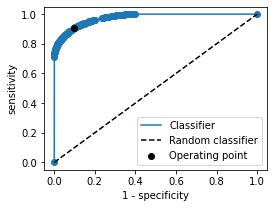

TEST SET
Threshold: 0.46
TP: 3241
TN: 168737
FP: 96342
FN: 1786
Accuracy: 0.64
Sensitivity: 0.64
Specificity: 0.64
Precision: 0.03
Recall (Detection rate): 0.64
F1-score: 0.07
AUC: 0.65
FPR (False alarm rate): 0.36
FNR: 0.36
Kappa: 0.03


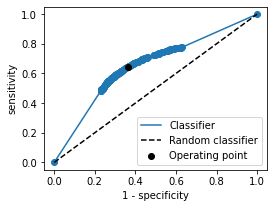

In [33]:
results_train_dt_uds_all, results_test_dt_uds_all, \
y_pred_prob_train_dt_uds, y_pred_prob_test_dt_uds = model_evaluation2(best_dt_uds, 
                                                                      X_uds, y_uds,
                                                                      X_test, y_test,
                                                                      print_ = 1)

### Save results to dataframe

In [0]:
dt_results_train = pd.DataFrame()
dt_results_test = pd.DataFrame()

In [0]:
dt_results_train = dt_results_train.append(results_train_dt_uds_all.rename(index={results_train_dt_uds_all.index[-1]: 'DT 50/50 Ratio All features'}))
dt_results_test = dt_results_test.append(results_test_dt_uds_all.rename(index={results_test_dt_uds_all.index[-1]: 'DT 50/50 Ratio All features'}))

### Random Under-sampling with Feature selection by Recursive Feature Elimination (RFE)

In [36]:
grid_dt_uds.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1}

In [0]:
dt_uds_fs = RFECV(estimator=best_dt_uds, step=1, cv=kfold, scoring='f1', n_jobs=-1)

In [38]:
start = datetime.now()

dt_uds_fs.fit(X_uds, y_uds)

print('Training took: ', datetime.now()-start)

Training took:  0:00:40.009280


### Optimal Number of features

In [39]:
print('Optimal number of features: {}'.format(dt_uds_fs.n_features_))

Optimal number of features: 16


### Plot the optimal number of features against F1-score

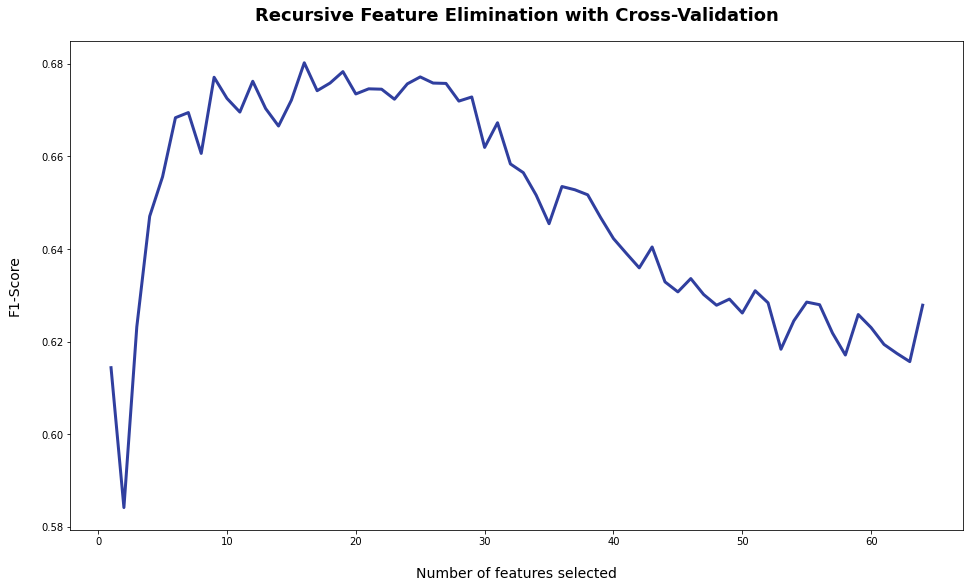

In [40]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('F1-Score', fontsize=14, labelpad=20)
plt.plot(range(1, len(dt_uds_fs.grid_scores_) + 1), dt_uds_fs.grid_scores_, color='#303F9F', linewidth=3)

### Now only select the important features according to the model

In [0]:
rfe_feat = dt_uds_fs.support_

### Use these selected features for Random Undersample dataset

In [0]:
X_uds_rfe, y_uds_rfe = rus.fit_resample(X_all.loc[:, rfe_feat], y_all)

In [45]:
X_all.loc[:, rfe_feat]

,Age,SBP_std,O2Sat_mean,Resp_mean,MAP_min,SBP_min,DBP_max,HR_max,Temp_max,Temp_min,SBP_max,Temp_std,DBP_mean,HR_mean,HR_std,MAP_std
0,-1.860827,-0.100423,-0.257952,0.225659,2.060733,2.428939,-1.108712,-0.249107,-0.228386,0.234737,2.025546,-0.887749,-0.735066,-0.494214,0.316975,0.998335
1,-0.893334,-0.426810,-0.962098,-0.403008,0.243862,-1.009552,-1.108712,-0.190966,-0.460255,-0.000762,-1.233596,-1.014934,-0.735066,-0.193393,0.018641,-1.053614
2,-0.946406,0.375703,1.098539,-1.616478,-0.022197,0.618126,-1.064903,-0.608517,0.173521,0.656408,0.444149,-1.014934,-0.688061,-0.331641,-1.002432,0.105426
3,1.516115,0.019747,0.928442,0.302074,-1.084504,0.404318,-2.325307,-1.152291,0.711251,0.641137,0.241785,0.112553,-2.717441,-0.887285,-1.305481,-0.609538
4,1.743260,-0.854744,-1.500226,0.677635,-2.525024,-0.606705,0.979952,-0.426486,-0.141851,-0.102561,-1.181838,0.379275,-1.110037,-0.342376,-0.632079,1.965759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080419,1.286585,-0.182119,-0.007601,-0.813487,-4.625750,-1.696299,-1.880021,-0.076105,-0.141851,0.324066,-1.719874,-0.852017,-1.911329,0.096527,-0.780957,1.182749
1080420,1.002704,0.937756,-0.702752,0.032604,-0.998816,0.380155,-0.770544,-0.608517,-0.286202,-0.246700,0.483862,0.305669,-0.927380,-0.256902,-2.049536,0.913415
1080421,0.378001,-0.327946,0.456106,-0.524617,0.922260,0.982956,0.927216,-0.547305,-0.431183,-0.102561,0.483862,-0.389907,1.151665,-0.864275,0.992460,-0.061506
1080422,-0.708957,0.382785,1.585655,0.110179,2.060733,1.158595,1.822917,0.680119,-0.026822,-0.160398,1.159590,0.245084,2.015088,0.694822,0.629348,0.552429


In [0]:
rfe_features = X_all.loc[:, rfe_feat].columns

In [47]:
rfe_features

Index(['Age', 'SBP_std', 'O2Sat_mean', 'Resp_mean', 'MAP_min', 'SBP_min',
       'DBP_max', 'HR_max', 'Temp_max', 'Temp_min', 'SBP_max', 'Temp_std',
       'DBP_mean', 'HR_mean', 'HR_std', 'MAP_std'],
      dtype='object')

### Model

In [48]:
start = datetime.now()

best_dt_uds.fit(X_uds_rfe, y_uds_rfe)

print('Training took: ', datetime.now()-start)

Training took:  0:00:00.300327


### Feature importance determined by the model

Text(0.5, 0, 'Relative Importance')

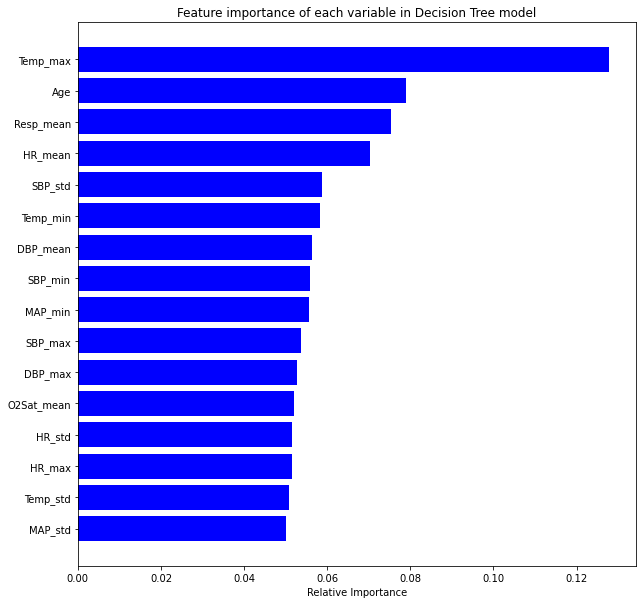

In [54]:
rcParams['figure.figsize'] = 10, 10
features = rfe_features
importances = best_dt_uds.feature_importances_
indices = np.argsort(importances)

plt.title('Feature importance of each variable in Decision Tree model')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

### Model Performance

TRAINING SET
Threshold: 0.44
TP: 17777
TN: 17904
FP: 2205
FN: 2332
Accuracy: 0.89
Sensitivity: 0.88
Specificity: 0.89
Precision: 0.89
Recall (Detection rate): 0.88
F1-score: 0.89
AUC: 0.97
FPR (False alarm rate): 0.11
FNR: 0.12
Kappa: 0.77


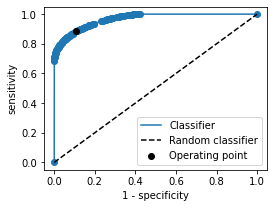

TEST SET
Threshold: 0.44
TP: 3501
TN: 176050
FP: 89029
FN: 1526
Accuracy: 0.66
Sensitivity: 0.7
Specificity: 0.66
Precision: 0.04
Recall (Detection rate): 0.7
F1-score: 0.09
AUC: 0.71
FPR (False alarm rate): 0.34
FNR: 0.3
Kappa: 0.04


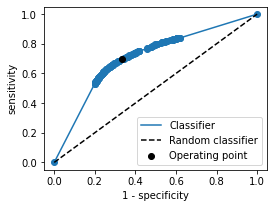

In [0]:
results_train_dt_uds_rfe, results_test_dt_uds_rfe, \
y_pred_prob_train_dt_rfe, y_pred_prob_test_dt_rfe = model_evaluation2(best_dt_uds, 
                                                                      X_uds_rfe, y_uds_rfe,
                                                                      X_test.loc[:, rfe_feat], y_test,
                                                                      print_ = 1)

### Save results to dataframe

In [0]:
dt_results_train = dt_results_train.append(results_train_dt_uds_rfe.rename(index={results_train_dt_uds_rfe.index[-1]: 'DT 50/50 Ratio with Feature selection'}))
dt_results_test = dt_results_test.append(results_test_dt_uds_rfe.rename(index={results_test_dt_uds_rfe.index[-1]: 'DT 50/50 Ratio with Feature selection'}))

# 80/20 Ratio: All features

In [0]:
grid_dt_uds.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1}

In [0]:
# create the model/estimator
dt_8020 = DecisionTreeClassifier(random_state=seed,
                                 criterion='entropy',
                                 max_depth=20,
                                 max_features='sqrt',
                                 min_samples_leaf=1)

In [0]:
start = datetime.now()

dt_8020.fit(X_8020, y_8020)

print('Training took: ', datetime.now()-start)

Training took:  0:00:01.082486


### Performance on training and test set

TRAINING SET
Threshold: 0.4
TP: 14404
TN: 78557
FP: 1879
FN: 5705
Accuracy: 0.92
Sensitivity: 0.72
Specificity: 0.98
Precision: 0.88
Recall (Detection rate): 0.72
F1-score: 0.79
AUC: 0.95
FPR (False alarm rate): 0.02
FNR: 0.28
Kappa: 0.75


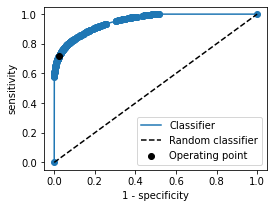

TEST SET
Threshold: 0.4
TP: 1862
TN: 234672
FP: 30407
FN: 3165
Accuracy: 0.88
Sensitivity: 0.37
Specificity: 0.89
Precision: 0.06
Recall (Detection rate): 0.37
F1-score: 0.11
AUC: 0.64
FPR (False alarm rate): 0.11
FNR: 0.63
Kappa: 0.07


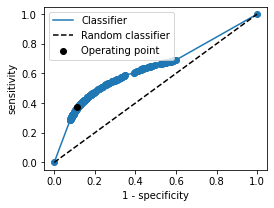

In [0]:
results_train_dt_8020, results_test_dt_8020, \
y_pred_prob_train_dt_8020, y_pred_prob_test_dt_8020 = model_evaluation2(dt_8020, 
                                                                        X_8020, y_8020,
                                                                        X_test, y_test,
                                                                        print_ = 1)

### Save results to dataframe

In [0]:
dt_results_train = dt_results_train.append(results_train_dt_8020.rename(index={results_train_dt_8020.index[-1]: 'DT 80/20 Ratio All features'}))
dt_results_test = dt_results_test.append(results_test_dt_8020.rename(index={results_test_dt_8020.index[-1]: 'DT 80/20 Ratio All features'}))

# 80/20 Ratio: Feature selection

In [0]:
# create the model/estimator
dt_8020_rfe = DecisionTreeClassifier(random_state=seed,
                                     criterion='entropy',
                                     max_depth=20,
                                     max_features='sqrt',
                                     min_samples_leaf=1)

### Use the selected features for 80/20 dataset

In [0]:
X_8020_rfe, y_8020_rfe = ratio8020.fit_resample(X_all.loc[:, rfe_feat], y_all)

### Model

In [0]:
start = datetime.now()

dt_8020_rfe.fit(X_8020_rfe, y_8020_rfe)

print('Training took: ', datetime.now()-start)

Training took:  0:00:00.720036


### Model Performance

TRAINING SET
Threshold: 0.41
TP: 15117
TN: 78737
FP: 1699
FN: 4992
Accuracy: 0.93
Sensitivity: 0.75
Specificity: 0.98
Precision: 0.9
Recall (Detection rate): 0.75
F1-score: 0.82
AUC: 0.96
FPR (False alarm rate): 0.02
FNR: 0.25
Kappa: 0.78


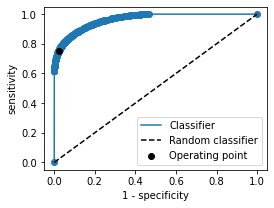

TEST SET
Threshold: 0.41
TP: 2387
TN: 238491
FP: 26588
FN: 2640
Accuracy: 0.89
Sensitivity: 0.47
Specificity: 0.9
Precision: 0.08
Recall (Detection rate): 0.47
F1-score: 0.15
AUC: 0.72
FPR (False alarm rate): 0.1
FNR: 0.53
Kappa: 0.11


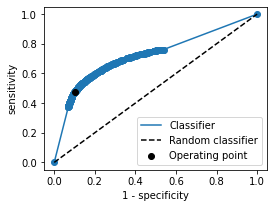

In [0]:
results_train_dt_8020_rfe, results_test_dt_8020_rfe, \
y_pred_prob_train_dt_8020_rfe, y_pred_prob_test_dt_8020_rfe = model_evaluation2(dt_8020_rfe, 
                                                                                X_8020_rfe, y_8020_rfe,
                                                                                X_test.loc[:, rfe_feat], y_test,
                                                                                print_ = 1)

### Save results to dataframe

In [0]:
dt_results_train = dt_results_train.append(results_train_dt_8020_rfe.rename(index={results_train_dt_8020_rfe.index[-1]: 'DT 80/20 Ratio with Feature Selection'}))
dt_results_test = dt_results_test.append(results_test_dt_8020_rfe.rename(index={results_test_dt_8020_rfe.index[-1]: 'DT 80/20 Ratio with Feature Selection'}))

# 90/10 Ratio: All features

In [0]:
grid_dt_uds.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1}

In [0]:
# create the model/estimator
dt_9010 = DecisionTreeClassifier(random_state=seed,
                                 criterion='entropy',
                                 max_depth=20,
                                 max_features='sqrt',
                                 min_samples_leaf=1)

In [0]:
start = datetime.now()

dt_9010.fit(X_9010, y_9010)

print('Training took: ', datetime.now()-start)

Training took:  0:00:01.983839


### Performance on training and test set

TRAINING SET
Threshold: 0.38
TP: 13105
TN: 179294
FP: 1687
FN: 7004
Accuracy: 0.96
Sensitivity: 0.65
Specificity: 0.99
Precision: 0.89
Recall (Detection rate): 0.65
F1-score: 0.75
AUC: 0.95
FPR (False alarm rate): 0.01
FNR: 0.35
Kappa: 0.73


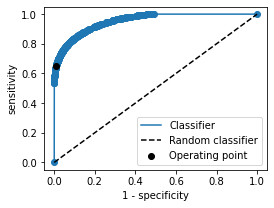

TEST SET
Threshold: 0.38
TP: 1313
TN: 251111
FP: 13968
FN: 3714
Accuracy: 0.93
Sensitivity: 0.26
Specificity: 0.95
Precision: 0.09
Recall (Detection rate): 0.26
F1-score: 0.13
AUC: 0.64
FPR (False alarm rate): 0.05
FNR: 0.74
Kappa: 0.1


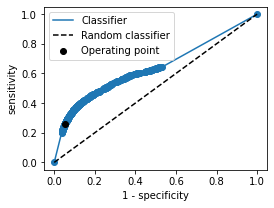

In [0]:
results_train_dt_9010, results_test_dt_9010, \
y_pred_prob_train_dt_9010, y_pred_prob_test_dt_9010 = model_evaluation2(dt_9010, 
                                                                        X_9010, y_9010,
                                                                        X_test, y_test,
                                                                        print_ = 1)

### Save results to dataframe

In [0]:
dt_results_train = dt_results_train.append(results_train_dt_9010.rename(index={results_train_dt_9010.index[-1]: 'DT 90/10 Ratio All features'}))
dt_results_test = dt_results_test.append(results_test_dt_9010.rename(index={results_test_dt_9010.index[-1]: 'DT 90/10 Ratio All features'}))

# 90/10 Ratio: Feature selection

In [0]:
# create the model/estimator
dt_9010_rfe = DecisionTreeClassifier(random_state=seed,
                                     criterion='entropy',
                                     max_depth=20,
                                     max_features='sqrt',
                                     min_samples_leaf=1)

### Use the selected features for 90/10 dataset

In [0]:
X_9010_rfe, y_9010_rfe = ratio9010.fit_resample(X_all.loc[:, rfe_feat], y_all)

### Model

In [0]:
start = datetime.now()

dt_9010_rfe.fit(X_9010_rfe, y_9010_rfe)

print('Training took: ', datetime.now()-start)

Training took:  0:00:01.391365


### Model Performance

TRAINING SET
Threshold: 0.39
TP: 13976
TN: 179196
FP: 1785
FN: 6133
Accuracy: 0.96
Sensitivity: 0.7
Specificity: 0.99
Precision: 0.89
Recall (Detection rate): 0.7
F1-score: 0.78
AUC: 0.97
FPR (False alarm rate): 0.01
FNR: 0.3
Kappa: 0.76


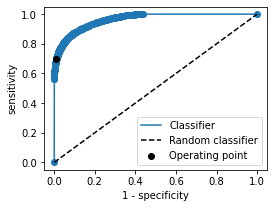

TEST SET
Threshold: 0.39
TP: 1916
TN: 252037
FP: 13042
FN: 3111
Accuracy: 0.94
Sensitivity: 0.38
Specificity: 0.95
Precision: 0.13
Recall (Detection rate): 0.38
F1-score: 0.2
AUC: 0.71
FPR (False alarm rate): 0.05
FNR: 0.62
Kappa: 0.17


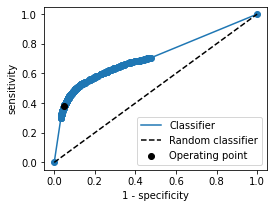

In [0]:
results_train_dt_9010_rfe, results_test_dt_9010_rfe, \
y_pred_prob_train_dt_9010_rfe, y_pred_prob_test_dt_9010_rfe = model_evaluation2(dt_9010_rfe, 
                                                                                X_9010_rfe, y_9010_rfe,
                                                                                X_test.loc[:, rfe_feat], y_test,
                                                                                print_ = 1)

### Save results to dataframe

In [0]:
dt_results_train = dt_results_train.append(results_train_dt_9010_rfe.rename(index={results_train_dt_9010_rfe.index[-1]: 'DT 90/10 Ratio with Feature Selection'}))
dt_results_test = dt_results_test.append(results_test_dt_9010_rfe.rename(index={results_test_dt_9010_rfe.index[-1]: 'DT 90/10 Ratio with Feature Selection'}))

# 95/05 Ratio: All features

In [0]:
grid_dt_uds.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1}

In [0]:
# create the model/estimator
dt_9505 = DecisionTreeClassifier(random_state=seed,
                                 criterion='entropy',
                                 max_depth=20,
                                 max_features='sqrt',
                                 min_samples_leaf=1)

In [0]:
start = datetime.now()

dt_9505.fit(X_9505, y_9505)

print('Training took: ', datetime.now()-start)

Training took:  0:00:03.850655


### Performance on training and test set

TRAINING SET
Threshold: 0.34
TP: 11246
TN: 380402
FP: 1669
FN: 8863
Accuracy: 0.97
Sensitivity: 0.56
Specificity: 1.0
Precision: 0.87
Recall (Detection rate): 0.56
F1-score: 0.68
AUC: 0.94
FPR (False alarm rate): 0.0
FNR: 0.44
Kappa: 0.67


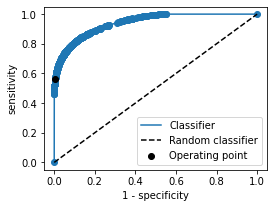

TEST SET
Threshold: 0.34
TP: 914
TN: 258463
FP: 6616
FN: 4113
Accuracy: 0.96
Sensitivity: 0.18
Specificity: 0.98
Precision: 0.12
Recall (Detection rate): 0.18
F1-score: 0.15
AUC: 0.62
FPR (False alarm rate): 0.02
FNR: 0.82
Kappa: 0.13


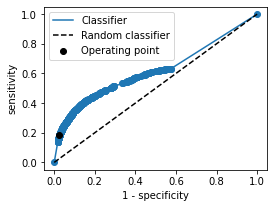

In [0]:
results_train_dt_9505, results_test_dt_9505, \
y_pred_prob_train_dt_9505, y_pred_prob_test_dt_9505 = model_evaluation2(dt_9505, 
                                                                        X_9505, y_9505,
                                                                        X_test, y_test,
                                                                        print_ = 1)

### Save results to dataframe

In [0]:
dt_results_train = dt_results_train.append(results_train_dt_9505.rename(index={results_train_dt_9505.index[-1]: 'DT 95/05 Ratio All features'}))
dt_results_test = dt_results_test.append(results_test_dt_9505.rename(index={results_test_dt_9505.index[-1]: 'DT 95/05 Ratio All features'}))

# 95/05 Ratio: Feature selection

In [0]:
# create the model/estimator
dt_9505_rfe = DecisionTreeClassifier(random_state=seed,
                                     criterion='entropy',
                                     max_depth=20,
                                     max_features='sqrt',
                                     min_samples_leaf=1)

### Use the selected features for 95/05 dataset

In [0]:
X_9505_rfe, y_9505_rfe = ratio9505.fit_resample(X_all.loc[:, rfe_feat], y_all)

### Model

In [0]:
start = datetime.now()

dt_9505_rfe.fit(X_9505_rfe, y_9505_rfe)

print('Training took: ', datetime.now()-start)

Training took:  0:00:02.724081


### Model Performance

TRAINING SET
Threshold: 0.34
TP: 11570
TN: 379896
FP: 2175
FN: 8539
Accuracy: 0.97
Sensitivity: 0.58
Specificity: 0.99
Precision: 0.84
Recall (Detection rate): 0.58
F1-score: 0.68
AUC: 0.95
FPR (False alarm rate): 0.01
FNR: 0.42
Kappa: 0.67


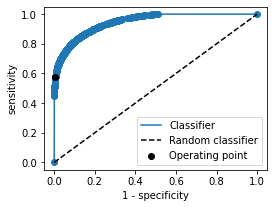

TEST SET
Threshold: 0.34
TP: 1465
TN: 259551
FP: 5528
FN: 3562
Accuracy: 0.97
Sensitivity: 0.29
Specificity: 0.98
Precision: 0.21
Recall (Detection rate): 0.29
F1-score: 0.25
AUC: 0.72
FPR (False alarm rate): 0.02
FNR: 0.71
Kappa: 0.23


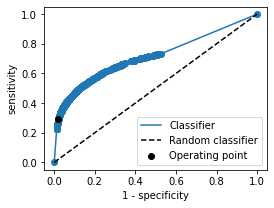

In [0]:
results_train_dt_9505_rfe, results_test_dt_9505_rfe, \
y_pred_prob_train_dt_9505_rfe, y_pred_prob_test_dt_9505_rfe = model_evaluation2(dt_9505_rfe, 
                                                                                X_9505_rfe, y_9505_rfe,
                                                                                X_test.loc[:, rfe_feat], y_test,
                                                                                print_ = 1)

### Save results to dataframe

In [0]:
dt_results_train = dt_results_train.append(results_train_dt_9505_rfe.rename(index={results_train_dt_9505_rfe.index[-1]: 'DT 95/05 Ratio with Feature Selection'}))
dt_results_test = dt_results_test.append(results_test_dt_9505_rfe.rename(index={results_test_dt_9505_rfe.index[-1]: 'DT 95/05 Ratio with Feature Selection'}))

# 98/02 Ratio: All features

In [0]:
grid_dt_uds.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1}

In [0]:
# create the model/estimator
dt_9802 = DecisionTreeClassifier(random_state=seed,
                                 criterion='entropy',
                                 max_depth=20,
                                 max_features='sqrt',
                                 min_samples_leaf=1)

In [0]:
start = datetime.now()

dt_9802.fit(X_all, y_all)

print('Training took: ', datetime.now()-start)

Training took:  0:00:12.396393


### Performance on training and test set

TRAINING SET
Threshold: 0.31
TP: 9553
TN: 1058692
FP: 1623
FN: 10556
Accuracy: 0.99
Sensitivity: 0.48
Specificity: 1.0
Precision: 0.85
Recall (Detection rate): 0.48
F1-score: 0.61
AUC: 0.93
FPR (False alarm rate): 0.0
FNR: 0.52
Kappa: 0.61


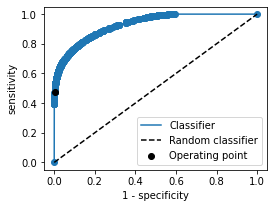

TEST SET
Threshold: 0.31
TP: 735
TN: 263096
FP: 1983
FN: 4292
Accuracy: 0.98
Sensitivity: 0.15
Specificity: 0.99
Precision: 0.27
Recall (Detection rate): 0.15
F1-score: 0.19
AUC: 0.61
FPR (False alarm rate): 0.01
FNR: 0.85
Kappa: 0.18


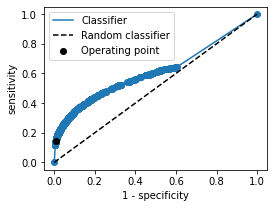

In [0]:
results_train_dt_9802, results_test_dt_9802, \
y_pred_prob_train_dt_9802, y_pred_prob_test_dt_9802 = model_evaluation2(dt_9802, 
                                                                        X_all, y_all,
                                                                        X_test, y_test,
                                                                        print_ = 1)

### Save results to dataframe

In [0]:
dt_results_train = dt_results_train.append(results_train_dt_9802.rename(index={results_train_dt_9802.index[-1]: 'DT 98/02 Ratio All features'}))
dt_results_test = dt_results_test.append(results_test_dt_9802.rename(index={results_test_dt_9802.index[-1]: 'DT 98/02 Ratio All features'}))

# 98/02 Ratio: Feature selection

In [0]:
# create the model/estimator
dt_9802_rfe = DecisionTreeClassifier(random_state=seed,
                                     criterion='entropy',
                                     max_depth=20,
                                     max_features='sqrt',
                                     min_samples_leaf=1)

### Use the selected features for 98/02 dataset

In [0]:
X_9802_rfe, y_9802_rfe = X_all.loc[:, rfe_feat], y_all

### Model

In [0]:
start = datetime.now()

dt_9802_rfe.fit(X_9802_rfe, y_9802_rfe)

print('Training took: ', datetime.now()-start)

Training took:  0:00:08.219406


### Model Performance

TRAINING SET
Threshold: 0.33
TP: 10673
TN: 1058657
FP: 1658
FN: 9436
Accuracy: 0.99
Sensitivity: 0.53
Specificity: 1.0
Precision: 0.87
Recall (Detection rate): 0.53
F1-score: 0.66
AUC: 0.95
FPR (False alarm rate): 0.0
FNR: 0.47
Kappa: 0.65


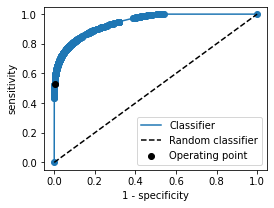

TEST SET
Threshold: 0.33
TP: 1223
TN: 263319
FP: 1760
FN: 3804
Accuracy: 0.98
Sensitivity: 0.24
Specificity: 0.99
Precision: 0.41
Recall (Detection rate): 0.24
F1-score: 0.31
AUC: 0.7
FPR (False alarm rate): 0.01
FNR: 0.76
Kappa: 0.3


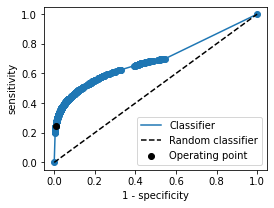

In [0]:
results_train_dt_9802_rfe, results_test_dt_9802_rfe, \
y_pred_prob_train_dt_9802_rfe, y_pred_prob_test_dt_9802_rfe = model_evaluation2(dt_9802_rfe, 
                                                                                X_9802_rfe, y_9802_rfe,
                                                                                X_test.loc[:, rfe_feat], y_test,
                                                                                print_ = 1)

### Save results to dataframe

In [0]:
dt_results_train = dt_results_train.append(results_train_dt_9802_rfe.rename(index={results_train_dt_9802_rfe.index[-1]: 'DT 98/02 Ratio with Feature Selection'}))
dt_results_test = dt_results_test.append(results_test_dt_9802_rfe.rename(index={results_test_dt_9802_rfe.index[-1]: 'DT 98/02 Ratio with Feature Selection'}))

### Save the training and test dataframes to csv files

In [0]:
dt_results_train.to_csv('DT_Train_Results.csv', index=True)
dt_results_test.to_csv('DT_Test_Results.csv', index=True)